# Fashion-MNIST

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from mxnet.gluon import data as gdata
from mxnet import ndarray as nd
from mxnet import autograd, nd
import math
import sys
import time

### Download the dataset

In [2]:
mnist_train = gdata.vision.FashionMNIST(train=True)
mnist_test  = gdata.vision.FashionMNIST(train=False)
print(len(mnist_train),len(mnist_test))

60000 10000


### Access one experiment

In [3]:
feature, label = mnist_train[0]
print(feature.shape, feature.dtype, label, type(label), label.dtype)

(28, 28, 1) <class 'numpy.uint8'> 2 <class 'numpy.int32'> int32


### Set labels

In [4]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                  'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

### Display some of training data

In [5]:
def show_fashion_mnist(images, labels):
    fig, axs = plt.subplots(1, len(images),figsize=(12,12))
    for f, img, lbl in zip(axs, images, labels):
        f.imshow(img.reshape((28,28)).asnumpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

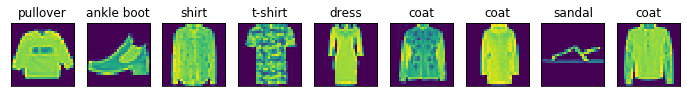

In [6]:
X, y = mnist_train[0:9]
show_fashion_mnist(X, get_fashion_mnist_labels(y))

### Load data in batches

In [7]:
batch_size = 256
transformer = gdata.vision.transforms.ToTensor()
if sys.platform.startswith('win'):
    num_workers = 0
else:
    num_workers = 4
    
train_iter = gdata.DataLoader(mnist_train.transform_first(transformer),
                             batch_size, shuffle=True,
                             num_workers=num_workers)
test_iter = gdata.DataLoader(mnist_test.transform_first(transformer),
                            batch_size, shuffle=False,
                            num_workers=num_workers)

### Initialize model parameter

In [56]:
num_inputs = 784  # we have 28x28 images
num_outputs = 10  # different labels

W = nd.random.normal(scale=0.01, shape=(num_inputs, num_outputs))
b = nd.zeros(num_outputs)

# Attach gradients
W.attach_grad()
b.attach_grad()

### Define the model

In [57]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(axis=1, keepdims=True)
    return X_exp / partition # using broadcast

In [58]:
def net(X):
    return softmax(nd.dot(X.reshape((-1, num_inputs)), W) + b)

### Define the loss function

In [59]:
def cross_entropy(y_hat, y):
    return -nd.pick(y_hat, y).log()

### Define classification accuracy

In [60]:
def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1) == y_astype('float32')).mean().asscalar()

def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        y = y.astype('float32')
        acc_sum += (net(X).argmax(axis=1) == y).sum().asscalar()
        n += y.size
    return acc_sum / n

In [61]:
evaluate_accuracy(test_iter, net)

0.1127

### Training loop

In [62]:
# Model training helper
def train(net, train_iter, test_iter, loss, num_epochs, batch_size,
         params=None, lr=None, trainer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            if trainer is None:
                for param in params:
                    param[:] = param - lr * param.grad / batch_size
            else:
                trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1)==y).sum().asscalar()
            n += y.size
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
             % (epoch+1, train_l_sum / n, train_acc_sum / n, test_acc))

In [63]:
num_epochs, lr = 10, 0.1
train(net, train_iter, test_iter, cross_entropy, num_epochs,
     batch_size, [W,b], lr)

epoch 1, loss 0.7887, train acc 0.748, test acc 0.803
epoch 2, loss 0.5733, train acc 0.811, test acc 0.825
epoch 3, loss 0.5292, train acc 0.825, test acc 0.833
epoch 4, loss 0.5050, train acc 0.830, test acc 0.832
epoch 5, loss 0.4891, train acc 0.835, test acc 0.836
epoch 6, loss 0.4783, train acc 0.837, test acc 0.843
epoch 7, loss 0.4698, train acc 0.841, test acc 0.846
epoch 8, loss 0.4616, train acc 0.843, test acc 0.843
epoch 9, loss 0.4561, train acc 0.845, test acc 0.849
epoch 10, loss 0.4515, train acc 0.846, test acc 0.849


### Prediction

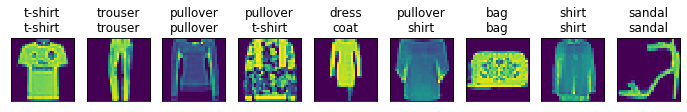

In [64]:
for X, y in test_iter:
    break
    
true_labels = get_fashion_mnist_labels(y.asnumpy())
pred_labels = get_fashion_mnist_labels(net(X).argmax(axis=1).asnumpy())

titles = [truelabel + '\n' + predlabel for truelabel, predlabel in zip(true_labels, pred_labels)]
show_fashion_mnist(X[0:9], titles[0:9])

# Using Gluon

### Define the model

In [49]:
from mxnet.gluon import nn

net = nn.Sequential()
net.add(nn.Dense(10))

### Define classification accuracy

In [50]:
def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1) == y.astype('float32')).sum().asscalar()

In [51]:
def evaluate_accuracy(net, data_iter, ctx=None):
    if not ctx:  # Query the first device the first parameter is on.
        ctx = list(net.collect_params().values())[0].list_ctx()[0]
    metric = [0.0, 0]  # num_corrected_examples, num_examples
    for X, y in data_iter:
        X, y = X.as_in_context(ctx), y.as_in_context(ctx)
        metric[0] = metric[0] + accuracy(net(X), y)
        metric[1] = metric[1] + y.size
    return metric[0]/metric[1]

In [52]:
from mxnet import context

# Helper
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    return context.gpu(i) if context.num_gpus() >= i + 1 else context.cpu()

### Training loop

In [53]:
from mxnet import gluon, init

def train(net, train_iter, test_iter, num_epochs, lr, ctx=try_gpu()):
    net.initialize(force_reinit=True, ctx=ctx, init=init.Xavier())
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(),
                            'sgd', {'learning_rate': lr})
    for epoch in range(num_epochs):
        metric = [0.0,0.0,0]  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            X, y = X.as_in_context(ctx), y.as_in_context(ctx)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y)
            l.backward()
            trainer.step(X.shape[0])
            # Update metrics
            metric[0] = metric[0] + l.sum().asscalar()
            metric[1] = metric[1] + accuracy(y_hat, y)
            metric[2] = metric[2] + X.shape[0]
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
        test_acc = evaluate_accuracy(net, test_iter)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
             % (epoch+1, train_loss, train_acc, test_acc))
    print('loss %.3f, train acc %.3f, test acc %.3f' % (train_loss, train_acc, test_acc))

In [54]:
lr, num_epochs = 0.9, 10
train(net, train_iter, test_iter, num_epochs, lr)

epoch 1, loss 3.1160, train acc 0.703, test acc 0.703
epoch 2, loss 1.7924, train acc 0.771, test acc 0.795
epoch 3, loss 1.6420, train acc 0.785, test acc 0.812
epoch 4, loss 1.5685, train acc 0.790, test acc 0.791
epoch 5, loss 1.4081, train acc 0.799, test acc 0.781
epoch 6, loss 1.4208, train acc 0.801, test acc 0.846
epoch 7, loss 1.3324, train acc 0.805, test acc 0.738
epoch 8, loss 1.4045, train acc 0.804, test acc 0.809
epoch 9, loss 1.3283, train acc 0.807, test acc 0.674
epoch 10, loss 1.4558, train acc 0.802, test acc 0.744
loss 1.456, train acc 0.802, test acc 0.744


### Prediction

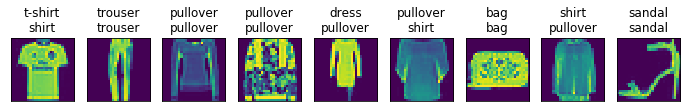

In [55]:
for X, y in test_iter:
    break
    
true_labels = get_fashion_mnist_labels(y.asnumpy())
pred_labels = get_fashion_mnist_labels(net(X).argmax(axis=1).asnumpy())

titles = [truelabel + '\n' + predlabel for truelabel, predlabel in zip(true_labels, pred_labels)]
show_fashion_mnist(X[0:9], titles[0:9])